In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.append(str(Path("..").resolve()))
from ast import literal_eval
from sdm import visualize_skillcorner as vsc
from sdm import visualize_features as vf
from IPython.display import HTML
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import os
from functools import partial
from sdm import visualize_features as vf
from unxpass.datasets import PassesDataset
from unxpass.components.withSpeeds import pass_selection_speeds, pass_value_speeds
import mlflow
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
proj_root = "/home/lz80/asi_goalkeeper_positioning"
sys.path.append(os.path.join(proj_root, "scripts/test"))
from get_diffs import generate_gk_position_surface

In [10]:
wyscout = pd.read_parquet("/home/lz80/rdf/sp161/shared/asi_gk_pos/data/wyscout_events_2026.parquet")

In [2]:
diffs = pd.read_csv("/home/lz80/asi_goalkeeper_positioning/stores/frame_results.csv")
gks = diffs.groupby("gk_id")['diff'].agg(['mean', 'count']).sort_values(by = 'mean')

In [ ]:
meta = pd.read_csv("/home/lz80/rdf/sp161/shared/asi_gk_pos/data/matches_meta.csv")


In [8]:
gks_l = meta['players'].apply(lambda x: {player['id'] : player['short_name'] for player in literal_eval(x) if player['player_role']['acronym'] == 'GK'})
from functools import reduce
big = reduce(lambda x, y: {**x, **y}, gks_l)

In [9]:
gks = gks.reset_index()
gks['name'] = gks['gk_id'].map(big)
gks[gks['count'] >= 1000].sort_values(by = "mean", ascending = False).head(5)

,gk_id,mean,count,name
23,57129,0.005700,10504,K. Lund
22,22829,0.005301,6321,A. Franch
21,634736,0.005170,1141,A. Anderson
19,151143,0.004979,1847,C. Miller
18,167381,0.004929,2468,L. Proulx


In [ ]:
meta['date_time'] = pd.to_datetime(meta['date_time'])
cutoff = meta['date_time'].quantile(0.5)
meta['season_half'] = (meta['date_time'] > cutoff).map(
    {False: 'first', True: 'second'}
)

In [8]:
first_half = meta[meta['season_half'] == 'first']['id']
second_half = meta[meta['season_half'] == 'second']['id']
firstdiffs = diffs[diffs['match_id'].isin(first_half)]
seconddiffs = diffs[diffs['match_id'].isin(second_half)]

In [9]:
first_gk = firstdiffs.groupby("gk_id")['diff'].agg(['mean', 'count']).sort_values(by = 'mean')
second_gk = seconddiffs.groupby("gk_id")['diff'].agg(['mean', 'count']).sort_values(by = 'mean')

In [10]:
merged = pd.merge(first_gk, second_gk, left_index = True, right_index = True)
merged
merged[["mean_x", "mean_y"]].corr()

,mean_x,mean_y
mean_x,1.000000,0.397349
mean_y,0.397349,1.000000


In [15]:
first_gk.shape[0], second_gk.shape[0]

(23, 17)

In [18]:
gks

,gk_id,mean,count,name
0,169916,-0.000121,690,C. Roque
1,151216,0.001347,660,H. Beall
2,22573,0.001420,1836,M. Arnold
3,151201,0.001534,10917,D. Haracic
4,151090,0.001700,9938,S. Hogan
5,151608,0.002003,3768,Laurel Ivory
6,177501,0.002560,12473,Mandy Haught
7,57139,0.002819,8057,K. Rowland
8,627213,0.002936,479,M. Wood
9,57092,0.002946,6836,A. Berger


In [17]:
merged

,mean_x,count_x,mean_y,count_y
gk_id,,,,
151090,0.002243,7699,-0.000168,2239
22573,0.002248,1017,0.000391,819
177501,0.002513,10183,0.002766,2290
151201,0.002514,8402,-0.001740,2515
57139,0.003382,5126,0.001835,2931
57092,0.003775,4196,0.001629,2640
57135,0.004099,7300,0.003279,2352
22734,0.004525,6218,0.001937,2059
151616,0.004712,4568,0.002419,2457


(-0.002757822483047056, 0.006296379495143189)

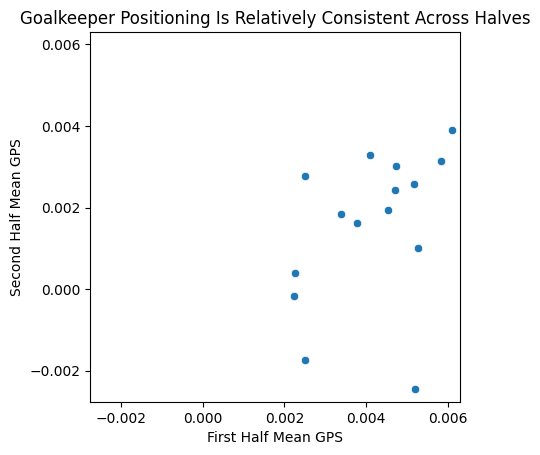

In [25]:
merged
import seaborn as sns
fig = sns.scatterplot(data=merged, x="mean_x", y="mean_y")
plt.title('Goalkeeper Positioning Is Relatively Consistent Across Halves')
plt.xlabel('First Half Mean GPS')
plt.ylabel('Second Half Mean GPS')

# Make plot square with equal scaling
ax = plt.gca()
ax.set_aspect('equal', 'box')

# Optional: force same limits on both axes
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
ax.set_xlim(lims)
ax.set_ylim(lims)


In [4]:
diffs['diff_play'] = diffs['frame'] - 1 != diffs['frame'].shift(1)
diffs['play_id'] = diffs['diff_play'].cumsum() - 1
diffs

,match_id,frame,gk_id,expected,actual,diff,diff_play,play_id
0,1448682,120,62526,0.024577,0.021973,0.002604,True,0
1,1448682,121,62526,0.013473,0.017694,-0.004221,False,0
2,1448682,122,62526,-0.000258,0.010262,-0.010520,False,0
3,1448682,123,62526,0.008404,-0.007901,0.016305,False,0
4,1448682,124,62526,0.003405,0.000023,0.003382,False,0
...,...,...,...,...,...,...,...,...
151404,1875301,62223,149873,0.048106,0.030078,0.018028,True,7194
151405,1875301,62224,149873,0.031539,0.027934,0.003605,False,7194
151406,1875301,62225,149873,0.023320,0.009455,0.013865,False,7194
151407,1875301,62226,149873,0.011767,0.000390,0.011377,False,7194


In [5]:
plays =diffs.groupby("play_id")['diff', 'match_id', 'frame'].agg('mean').sort_values(by = 'diff', ascending = False).reset_index()

<positron-console-cell-5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [6]:
iter = 232 #iter = 50, 108, 198, 212?, 232
match, frame, play, diff = plays[['match_id', 'frame', 'play_id', 'diff']].iloc[iter]
diff

0.027937067667838118

[12/31/25 21:32:49] INFO     Animation.save using <class       ]8;id=575849;file:///home/lz80/.venv/lib/python3.10/site-packages/matplotlib/animation.py\animation.py]8;;\:]8;id=468242;file:///home/lz80/.venv/lib/python3.10/site-packages/matplotlib/animation.py#1052\1052]8;;\
                             'matplotlib.animation.HTMLWriter'                  
                             >                                                  


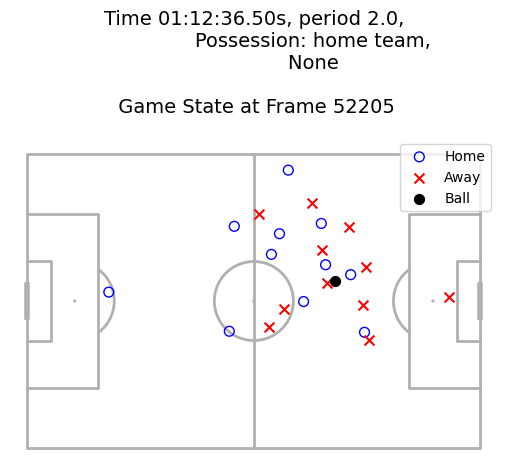

In [7]:
tracking = f"/home/lz80/rdf/sp161/shared/asi_gk_pos/data/tracking/{int(match)}_tracking.csv"
track_df = pd.read_csv(tracking)
home_team = vsc.get_players(match, meta)[0]
anim = vsc.animate_gamestate(track_df, range(int(frame - 20), int(frame + 20)), home_team)
HTML(anim.to_jshtml())

In [8]:
meta[meta['id'] == match]

,id,home_team_score,away_team_score,date_time,stadium,home_team,home_team_kit,away_team,away_team_kit,home_team_coach,...,competition_edition,match_periods,competition_round,referees,players,status,home_team_side,ball,pitch_length,pitch_width
115,1765051,0,2,2024-10-05T00:00:00Z,"{'id': 1235, 'name': 'BBVA Compass Stadium', '...","{'id': 1831, 'name': 'Houston Dash, Women', 's...","{'id': 6583, 'team_id': 1831, 'season': {'id':...","{'id': 2337, 'name': 'Chicago Red Stars, Women...","{'id': 12877, 'team_id': 2337, 'season': {'id'...",NaN,...,"{'id': 800, 'competition': {'id': 126, 'area':...","[{'period': 1, 'name': 'period_1', 'start_fram...","{'id': 2305, 'name': 'Round 23', 'round_number...",[],"[{'player_role': {'id': 13, 'position_group': ...",closed,"['right_to_left', 'left_to_right']",{'trackable_object': 55},108,68


In [11]:
wyscout[(wyscout['sk_match_id'] == match) & (wyscout['frame'].between(frame - 50, frame + 50))][['type_primary', 'type_secondary', 'minute']]

,type_primary,type_secondary,minute
142256,pass,"[forward_pass, long_pass, pass_to_final_third,...",72
323218,duel,"[ground_duel, interception, offensive_duel]",72
324383,duel,"[defensive_duel, ground_duel, loss]",72


In [12]:

feats = "/home/lz80/rdf/sp161/shared/asi_gk_pos/gk_pos_model/feats"
end = "/home/lz80/rdf/sp161/shared/asi_gk_pos/gk_pos_model/poi"
for file in os.listdir(feats):
    df = pd.read_parquet(f"{feats}/{file}")
    df = df.loc[diffs[diffs['play_id'] == play][['match_id', 'frame']].values.tolist()]
    df.to_parquet(f"{end}/{file}")


In [13]:
model_pass_selection = pass_selection_speeds.SoccerMapComponent(
        model=mlflow.pytorch.load_model(
            'runs:/ceea16e4a0254542bccf1f953f91381b/model', map_location='cpu'
        )
    )
OG_PATH = "/home/lz80/rdf/sp161/shared/asi_gk_pos/gk_pos_model/"
TEST = f"{OG_PATH}/poi"
dataset_test = partial(PassesDataset, path=TEST)

ball_ff = pd.read_parquet(f"{TEST}/x_ball_freeze_frame.parquet")
ff = pd.read_parquet(f"{TEST}/x_player_freeze_frame.parquet")
value_features = pd.read_csv("/home/lz80/asi_goalkeeper_positioning/stores/value_features.csv").drop(columns = ['scores_xg'])

sel_surfaces = model_pass_selection.predict_surface(dataset_test)

[12/31/25 21:33:54] INFO     Loading dataset from                ]8;id=196417;file:///home/lz80/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=246350;file:///home/lz80/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\
                             /home/lz80/rdf/sp161/shared/asi_gk_                
                             pos/gk_pos_model/poi                               


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0:  75%|███████▌  | 12/16 [00:00<00:00, 49.00it/s]

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 53.35it/s]


In [14]:
val_model = xgb.XGBRegressor()
val_model.load_model('/home/lz80/asi_goalkeeper_positioning/stores/model/value_model_2.model')

In [15]:
from typing import Dict, Tuple, List
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
def plot_from_features(idx, ff,
                       ball_ff, surface, ax = None, log = False, show_max = False) -> None:
    """ 
    Plots an event from the raw feature set

    Parameters
    ------
        idx: Tuple[str, int]
            The index of the event
        ff: Dict[int, List[int]]
            The player freeze frame of the event
        ball_ff: Dict[int, List[int]]
            The ball freeze frame of the event
    """
    pitch = Pitch(pitch_type= "custom", pitch_length = 105, pitch_width = 68, half = True)
    if ax is None:
        fig, ax = pitch.draw()
    else:
        fig = ax.figure
        pitch.draw(ax=ax)
    ff_event = ff.loc[idx]
    ball_ff_event = ball_ff.loc[idx]

    player_ff = ff_event['player_freeze_frame']
    ball_x = ball_ff_event['ball_freeze_frame_x']
    ball_y = ball_ff_event['ball_freeze_frame_y']

    ball_x_velo = ball_ff_event['ball_freeze_frame_x_velo']
    ball_y_velo = ball_ff_event['ball_freeze_frame_y_velo']

    offense = [player for player in player_ff if player['in_possession']]
    defense = [player for player in player_ff
               if not player['in_possession'] and not player['opp_gk']]

    offense_x = [player['x'] for player in offense]
    offense_y = [player['y'] for player in offense]

    offense_x_end = [player['x'] + player['x_velo'] for player in offense]
    offense_y_end = [player['y'] + player['y_velo'] for player in offense]

    defense_x = [player['x'] for player in defense]
    defense_y = [player['y'] for player in defense]

    defense_x_end = [player['x'] + player['x_velo'] for player in defense]
    defense_y_end= [player['y'] + player['y_velo'] for player in defense]

    gk_x = [player['x'] for player in player_ff if player['opp_gk']][0]
    gk_y = [player['y'] for player in player_ff if player['opp_gk']][0]

    gk_x_end = [player['x'] + player['x_velo'] for player in player_ff if player['opp_gk']][0]
    gk_y_end = [player['y'] + player['y_velo'] for player in player_ff if player['opp_gk']][0]

    pitch.scatter(offense_x, offense_y, ax=ax, marker = 'o',
                edgecolors ='blue', facecolors = 'none', label='Offense', s=50)
    pitch.scatter(defense_x, defense_y, ax=ax, marker = 'x',
                c='red', label='Defense', s=50)

    pitch.scatter(ball_x, ball_y, ax=ax, c='black', label='Ball', s=50)

    pitch.scatter(gk_x, gk_y, ax = ax, marker = 'o',
                edgecolors ='red', facecolors = 'none', label='Goalkeeper', s=50)

    #pitch.arrows(offense_x, offense_y, offense_x_end, offense_y_end,
    #            width = 2, headwidth = 5, color = 'blue', ax = ax)

    #pitch.arrows(defense_x, defense_y, defense_x_end, defense_y_end,
    #            width = 2, headwidth = 5, color = 'red', ax = ax)

    #pitch.arrows(ball_x, ball_y, ball_x + ball_x_velo,
    #             ball_y + ball_y_velo, width = 2, headwidth = 5, color = 'black', ax = ax)

    #pitch.arrows(gk_x, gk_y, gk_x_end, gk_y_end,
    #            width = 2, headwidth = 5, color = 'red', ax = ax)

    if surface is not None:
        plt_settings = {"interpolation": "bilinear"}

        positive_vals = surface[surface > 0]
        if positive_vals.size > 0:
            vmin = np.nanmin(positive_vals)
        else:
            vmin = 1e-6  # fallback if everything is <= 0

        vmax = np.nanmax(surface)

        plt_settings = {"interpolation": "bilinear"}
        if log:
            surface_kwargs = {
                **plt_settings,
                "norm": LogNorm(vmin=vmin, vmax=vmax),
                "cmap": "Greens",
            }
        else:
            surface_kwargs = {
                **plt_settings,
                "cmap": "RdYlGn",
            }
        masked_surface = np.ma.masked_where(surface == 0, surface)
        ax.imshow(masked_surface, extent=[0.0, 105.0, 0.0, 68.0], origin="lower", **surface_kwargs)
        if show_max:
            masked = np.where(surface > 0, surface, np.inf)
            iy, ix = np.unravel_index(np.argmin(masked), masked.shape)
            pitch.scatter(ix, iy, ax = ax, marker = 'o', color = 'yellow', label = 'Best Position', s = 25)

    ax.legend()
    fig.tight_layout()
    return fig

Text(0.5, 0.93, 'Green Means Better Position')

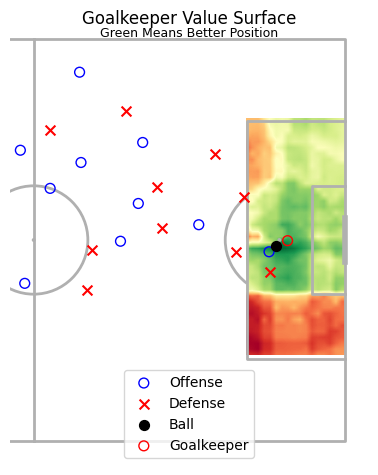

In [21]:
idx = (match, int(frame))
feats = value_features[(value_features['match_id'] == match) & (value_features['frame'] == int(frame))]
feats.index = pd.MultiIndex.from_tuples(
    [idx], 
    names=["match_id", "frame"]
) #this is really dumb.
surf_val = generate_gk_position_surface(idx, feats, ball_ff, ff, val_model)
#fig = plot_from_features(idx, ff, ball_ff, sel_surfaces[idx[0]][idx[1]], log = True)
fig = plot_from_features(idx, ff, ball_ff, -1 * surf_val, log = False)
fig.suptitle("Goalkeeper Value Surface")
fig.text(0.5, 0.93, 'Green Means Better Position', ha='center', va='center', fontsize=9)

In [ ]:
#could be good:
# (1748372.0, 37039.5)

,match_id,frame,gk_id,expected,actual,diff,optimal
0,1836364,46371,654389,0.157299,0.183908,-0.026609,0.092238
1,1836364,46372,654389,0.177833,0.204863,-0.027031,0.112659
2,1836364,46373,654389,0.084981,0.092758,-0.007777,0.036074
3,1836364,46374,654389,0.103948,0.100621,0.003327,0.064789
4,1836364,46375,654389,0.195358,0.188730,0.006628,0.152495
5,1836364,46376,654389,0.203659,0.250936,-0.047277,0.137972
6,1836364,46377,654389,0.123288,0.142516,-0.019228,0.084246
7,1836364,46378,654389,0.083015,0.101054,-0.018039,0.056243
8,1836364,46379,654389,0.101396,0.116439,-0.015043,0.035725
9,1836364,46380,654389,0.136652,0.172341,-0.035689,0.086118
